### Classification of vibrato type from hand movement sensors

In [244]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
# fix random seed for reproducibility
tf.random.set_seed(666)

In [245]:
# load all data
X = []
y = []
max_seq_size = 0
data_path = "data-processed"
data_points = [point for point in os.listdir(data_path) if point != '.DS_Store']
for dir in data_points:
    data_point_path = os.path.join(data_path, dir)
    for file_name in os.listdir(data_point_path):
        #if file_name.endswith('.npy'):
        if file_name.endswith('pre-processed.npy'):
            filepath = os.path.join(data_point_path, file_name)
            file = np.load(filepath)
            if file.shape[1] > max_seq_size:
                max_seq_size = file.shape[1]
            if file_name.split('-')[3] == 'left':
                #print(file_name)
                X.append(file)
                if file_name.split('-')[1] == 'static':
                    y.append(0) # static
                if file_name.split('-')[1] == 'vertical':
                    y.append(1) # vertical
                if file_name.split('-')[1] == 'horizontal':
                    #y.append(2) # horizontal
                    y.append(1) # horizontal
                if file_name.split('-')[1] == 'circular':
                    #y.append(3) # circular
                    y.append(1) # horizontal
print(f'Max sequence size: {max_seq_size}')
print(f'X size: {len(X)}')
print(f'y size: {len(y)}')

Max sequence size: 1142
X size: 517
y size: 517


In [246]:
# format sequences
X_acc_x = np.zeros(len(X), dtype=object)
X_acc_y = np.zeros(len(X), dtype=object)
X_acc_z = np.zeros(len(X), dtype=object)
X_gyro_x = np.zeros(len(X), dtype=object)
X_gyro_y = np.zeros(len(X), dtype=object)
X_gyro_z = np.zeros(len(X), dtype=object)

for i in range(len(X)):
    X_acc_x[i] = X[i][0,:].tolist()
    X_acc_y[i] = X[i][1,:].tolist()
    X_acc_z[i] = X[i][2,:].tolist()
    X_gyro_x[i] = X[i][3,:].tolist()
    X_gyro_y[i] = X[i][4,:].tolist()
    X_gyro_z[i] = X[i][5,:].tolist()

In [247]:
# pad sequences
X_acc_x_padded = sequence.pad_sequences(X_acc_x, maxlen=max_seq_size, dtype='float32', padding='post')
X_acc_y_padded = sequence.pad_sequences(X_acc_y, maxlen=max_seq_size, dtype='float32', padding='post')
X_acc_z_padded = sequence.pad_sequences(X_acc_z, maxlen=max_seq_size, dtype='float32', padding='post')
X_gyro_x_padded = sequence.pad_sequences(X_gyro_x, maxlen=max_seq_size, dtype='float32', padding='post')
X_gyro_y_padded = sequence.pad_sequences(X_gyro_y, maxlen=max_seq_size, dtype='float32', padding='post')
X_gyro_z_padded = sequence.pad_sequences(X_gyro_z, maxlen=max_seq_size, dtype='float32', padding='post')

In [248]:
# aggregate and normalize
X_temp = np.zeros((6, X_acc_x.reshape(-1).shape[0]))
X_temp[0,:] = X_acc_x_padded.reshape(-1)
X_temp[1,:] = X_acc_y_padded.reshape(-1)
X_temp[2,:] = X_acc_z_padded.reshape(-1)
X_temp[3,:] = X_gyro_x_padded.reshape(-1)
X_temp[4,:] = X_gyro_y_padded.reshape(-1)
X_temp[5,:] = X_gyro_z_padded.reshape(-1)

scaler = StandardScaler().fit(X_temp.T)
X = []
for i in range(X_acc_x_padded.shape[0]):
    X_temp = np.zeros((6, X_acc_x_padded.shape[1]))
    X_temp[0,:] = X_acc_x_padded[i,:]
    X_temp[1,:] = X_acc_y_padded[i,:]
    X_temp[2,:] = X_acc_z_padded[i,:]
    X_temp[3,:] = X_gyro_x_padded[i,:]
    X_temp[4,:] = X_gyro_y_padded[i,:]
    X_temp[5,:] = X_gyro_z_padded[i,:]
    X_temp = scaler.transform(X_temp.T)
    X.append(X_temp) # normalized array of dimensions N_samples, seq_len, num_sensors
np.array(X).shape

ValueError: could not broadcast input array from shape (590414,) into shape (517,)

Text(0.5, 0.98, 'Data point 10')

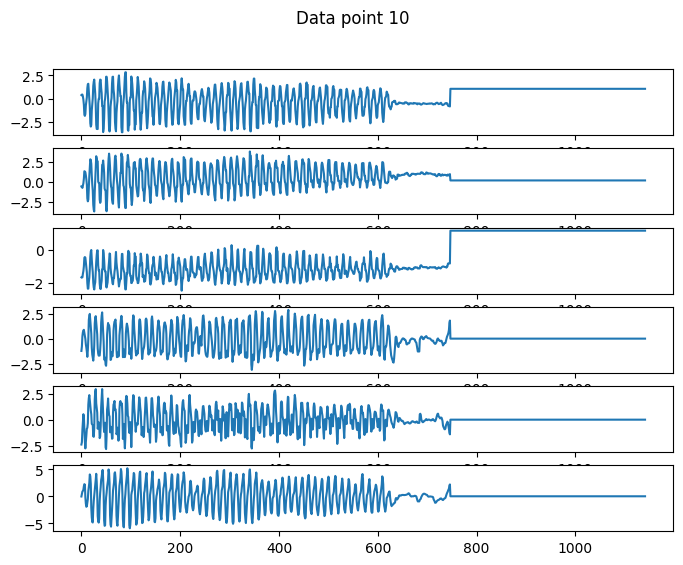

In [232]:
index = 10

fig, ax = plt.subplots(nrows=6, figsize=(8,6))
ax[0].plot(X[index][:,0])
ax[1].plot(X[index][:,1])
ax[2].plot(X[index][:,2])
ax[3].plot(X[index][:,3])
ax[4].plot(X[index][:,4])
ax[5].plot(X[index][:,5])
fig.suptitle(f'Data point {index}')

In [233]:
np.array(X).shape

(517, 1142, 6)

In [234]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.33, random_state=42)
y_train = to_categorical(y_train, num_classes=4) # one-hot encode
y_test = to_categorical(y_test, num_classes=4)

In [1]:
from tensorflow.keras.layers import Dropout
number_of_hidden_units = 100
no_of_epochs = 1000
batch_size = 128

model = Sequential()
model.add(LSTM(number_of_hidden_units, activation='tanh', input_shape=(max_seq_size, 6))) 
model.add(Dense(1)) #since number of output classes is 4
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=no_of_epochs, batch_size=batch_size)

KeyboardInterrupt: 

In [235]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(LSTM(256, input_shape=(max_seq_size, 6)))
model.add(Dense(4, activation='sigmoid'))
model.summary()

adam = Adam(lr=0.1)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', 
                      save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=200, batch_size=128, 
          callbacks=[chk], validation_data=(X_test, y_test))


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 256)               269312    
                                                                 
 dense_46 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 270340 (1.03 MB)
Trainable params: 270340 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.7601WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 9s 3s/step - loss: 0.6043 - accuracy: 0.7601 - val_loss: 0.4502 - val_accuracy: 0.7427
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.7572WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.3746 - accuracy: 0.7572 - val_loss: 0.3078 - val_accuracy: 0.7427
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.7514WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2986 - accuracy: 0.7514 - val_loss: 0.2927 - val_accuracy: 0.7368
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.7514WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2942 - accuracy: 0.7514 - val_loss: 0.2937 - val_accuracy: 0.7368
Epoch 5/200
3/3 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.7514WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2920 - accuracy: 0.7514 - val_loss: 0.2937 - val_accuracy: 0.7368
Epoch 6/200
3/3 [==============================] - ETA: 0s - loss: 0.2898 - accuracy: 0.7514WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2898 - accuracy: 0.7514 - val_loss: 0.2941 - val_accuracy: 0.7368
Epoch 7/200
3/3 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.7514WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2875 - accuracy: 0.7514 - val_loss: 0.2900 - val_accuracy: 0.7368
Epoch 8/200
3/3 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.7543WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2824 - accuracy: 0.7543 - val_loss: 0.2880 - val_accuracy: 0.7427
Epoch 9/200
3/3 [==============================] - ETA: 0s - loss: 0.2814 - accuracy: 0.7572WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2814 - accuracy: 0.7572 - val_loss: 0.2857 - val_accuracy: 0.7427
Epoch 10/200
3/3 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.7601WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2779 - accuracy: 0.7601 - val_loss: 0.2879 - val_accuracy: 0.7427
Epoch 11/200
3/3 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2754 - accuracy: 0.7630 - val_loss: 0.2874 - val_accuracy: 0.7427
Epoch 12/200
3/3 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.7659WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2736 - accuracy: 0.7659 - val_loss: 0.2858 - val_accuracy: 0.7427
Epoch 13/200
3/3 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2742 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 14/200
3/3 [==============================] - ETA: 0s - loss: 0.2749 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2749 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 15/200
3/3 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2750 - accuracy: 0.7630 - val_loss: 0.2860 - val_accuracy: 0.7427
Epoch 16/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2867 - val_accuracy: 0.7427
Epoch 17/200
3/3 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2742 - accuracy: 0.7630 - val_loss: 0.2865 - val_accuracy: 0.7427
Epoch 18/200
3/3 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2745 - accuracy: 0.7630 - val_loss: 0.2855 - val_accuracy: 0.7427
Epoch 19/200
3/3 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2744 - accuracy: 0.7630 - val_loss: 0.2855 - val_accuracy: 0.7427
Epoch 20/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2865 - val_accuracy: 0.7427
Epoch 21/200
3/3 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2758 - accuracy: 0.7630 - val_loss: 0.2895 - val_accuracy: 0.7427
Epoch 22/200
3/3 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2750 - accuracy: 0.7630 - val_loss: 0.2857 - val_accuracy: 0.7427
Epoch 23/200
3/3 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2750 - accuracy: 0.7630 - val_loss: 0.2853 - val_accuracy: 0.7427
Epoch 24/200
3/3 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2747 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 25/200
3/3 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2744 - accuracy: 0.7630 - val_loss: 0.2881 - val_accuracy: 0.7427
Epoch 26/200
3/3 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2750 - accuracy: 0.7630 - val_loss: 0.2869 - val_accuracy: 0.7427
Epoch 27/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 28/200
3/3 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2746 - accuracy: 0.7630 - val_loss: 0.2853 - val_accuracy: 0.7427
Epoch 29/200
3/3 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2758 - accuracy: 0.7630 - val_loss: 0.2855 - val_accuracy: 0.7427
Epoch 30/200
3/3 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 6s 2s/step - loss: 0.2747 - accuracy: 0.7630 - val_loss: 0.2858 - val_accuracy: 0.7427
Epoch 31/200
3/3 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2752 - accuracy: 0.7630 - val_loss: 0.2890 - val_accuracy: 0.7427
Epoch 32/200
3/3 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 6s 2s/step - loss: 0.2752 - accuracy: 0.7630 - val_loss: 0.2867 - val_accuracy: 0.7427
Epoch 33/200
3/3 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2748 - accuracy: 0.7630 - val_loss: 0.2853 - val_accuracy: 0.7427
Epoch 34/200
3/3 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2741 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 35/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2865 - val_accuracy: 0.7427
Epoch 36/200
3/3 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2743 - accuracy: 0.7630 - val_loss: 0.2862 - val_accuracy: 0.7427
Epoch 37/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2860 - val_accuracy: 0.7427
Epoch 38/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2855 - val_accuracy: 0.7427
Epoch 39/200
3/3 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2741 - accuracy: 0.7630 - val_loss: 0.2855 - val_accuracy: 0.7427
Epoch 40/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2855 - val_accuracy: 0.7427
Epoch 41/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 42/200
3/3 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2748 - accuracy: 0.7630 - val_loss: 0.2866 - val_accuracy: 0.7427
Epoch 43/200
3/3 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2746 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 44/200
3/3 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2741 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 45/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 9s 3s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 46/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2858 - val_accuracy: 0.7427
Epoch 47/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 9s 3s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2862 - val_accuracy: 0.7427
Epoch 48/200
3/3 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2743 - accuracy: 0.7630 - val_loss: 0.2865 - val_accuracy: 0.7427
Epoch 49/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2853 - val_accuracy: 0.7427
Epoch 50/200
3/3 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2741 - accuracy: 0.7630 - val_loss: 0.2853 - val_accuracy: 0.7427
Epoch 51/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2858 - val_accuracy: 0.7427
Epoch 52/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2861 - val_accuracy: 0.7427
Epoch 53/200
3/3 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2742 - accuracy: 0.7630 - val_loss: 0.2863 - val_accuracy: 0.7427
Epoch 54/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 55/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2852 - val_accuracy: 0.7427
Epoch 56/200
3/3 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2743 - accuracy: 0.7630 - val_loss: 0.2861 - val_accuracy: 0.7427
Epoch 57/200
3/3 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2742 - accuracy: 0.7630 - val_loss: 0.2858 - val_accuracy: 0.7427
Epoch 58/200
3/3 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 6s 2s/step - loss: 0.2743 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 59/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2863 - val_accuracy: 0.7427
Epoch 60/200
3/3 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2748 - accuracy: 0.7630 - val_loss: 0.2865 - val_accuracy: 0.7427
Epoch 61/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2852 - val_accuracy: 0.7427
Epoch 62/200
3/3 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2751 - accuracy: 0.7630 - val_loss: 0.2852 - val_accuracy: 0.7427
Epoch 63/200
3/3 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2746 - accuracy: 0.7630 - val_loss: 0.2861 - val_accuracy: 0.7427
Epoch 64/200
3/3 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2754 - accuracy: 0.7630 - val_loss: 0.2876 - val_accuracy: 0.7427
Epoch 65/200
3/3 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2750 - accuracy: 0.7630 - val_loss: 0.2853 - val_accuracy: 0.7427
Epoch 66/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 67/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2858 - val_accuracy: 0.7427
Epoch 68/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 69/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2857 - val_accuracy: 0.7427
Epoch 70/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2864 - val_accuracy: 0.7427
Epoch 71/200
3/3 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2746 - accuracy: 0.7630 - val_loss: 0.2857 - val_accuracy: 0.7427
Epoch 72/200
3/3 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2744 - accuracy: 0.7630 - val_loss: 0.2867 - val_accuracy: 0.7427
Epoch 73/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 74/200
3/3 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2741 - accuracy: 0.7630 - val_loss: 0.2852 - val_accuracy: 0.7427
Epoch 75/200
3/3 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2745 - accuracy: 0.7630 - val_loss: 0.2857 - val_accuracy: 0.7427
Epoch 76/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2860 - val_accuracy: 0.7427
Epoch 77/200
3/3 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 6s 2s/step - loss: 0.2742 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 78/200
3/3 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2741 - accuracy: 0.7630 - val_loss: 0.2858 - val_accuracy: 0.7427
Epoch 79/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 80/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 6s 2s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2853 - val_accuracy: 0.7427
Epoch 81/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 6s 2s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2859 - val_accuracy: 0.7427
Epoch 82/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 6s 2s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2867 - val_accuracy: 0.7427
Epoch 83/200
3/3 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2751 - accuracy: 0.7630 - val_loss: 0.2872 - val_accuracy: 0.7427
Epoch 84/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2852 - val_accuracy: 0.7427
Epoch 85/200
3/3 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2741 - accuracy: 0.7630 - val_loss: 0.2852 - val_accuracy: 0.7427
Epoch 86/200
3/3 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2743 - accuracy: 0.7630 - val_loss: 0.2858 - val_accuracy: 0.7427
Epoch 87/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2866 - val_accuracy: 0.7427
Epoch 88/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2860 - val_accuracy: 0.7427
Epoch 89/200
3/3 [==============================] - ETA: 0s - loss: 0.2735 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2735 - accuracy: 0.7630 - val_loss: 0.2852 - val_accuracy: 0.7427
Epoch 90/200
3/3 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2745 - accuracy: 0.7630 - val_loss: 0.2852 - val_accuracy: 0.7427
Epoch 91/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2863 - val_accuracy: 0.7427
Epoch 92/200
3/3 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2747 - accuracy: 0.7630 - val_loss: 0.2880 - val_accuracy: 0.7427
Epoch 93/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2857 - val_accuracy: 0.7427
Epoch 94/200
3/3 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2745 - accuracy: 0.7630 - val_loss: 0.2852 - val_accuracy: 0.7427
Epoch 95/200
3/3 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2744 - accuracy: 0.7630 - val_loss: 0.2857 - val_accuracy: 0.7427
Epoch 96/200
3/3 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2743 - accuracy: 0.7630 - val_loss: 0.2864 - val_accuracy: 0.7427
Epoch 97/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 6s 2s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2873 - val_accuracy: 0.7427
Epoch 98/200
3/3 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2742 - accuracy: 0.7630 - val_loss: 0.2861 - val_accuracy: 0.7427
Epoch 99/200
3/3 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2737 - accuracy: 0.7630 - val_loss: 0.2855 - val_accuracy: 0.7427
Epoch 100/200
3/3 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2736 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 101/200
3/3 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2737 - accuracy: 0.7630 - val_loss: 0.2855 - val_accuracy: 0.7427
Epoch 102/200
3/3 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2743 - accuracy: 0.7630 - val_loss: 0.2862 - val_accuracy: 0.7427
Epoch 103/200
3/3 [==============================] - ETA: 0s - loss: 0.2735 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2735 - accuracy: 0.7630 - val_loss: 0.2855 - val_accuracy: 0.7427
Epoch 104/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2853 - val_accuracy: 0.7427
Epoch 105/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 106/200
3/3 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2746 - accuracy: 0.7630 - val_loss: 0.2879 - val_accuracy: 0.7427
Epoch 107/200
3/3 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2755 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 108/200
3/3 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2733 - accuracy: 0.7630 - val_loss: 0.2857 - val_accuracy: 0.7427
Epoch 109/200
3/3 [==============================] - ETA: 0s - loss: 0.2735 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2735 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 110/200
3/3 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2732 - accuracy: 0.7630 - val_loss: 0.2862 - val_accuracy: 0.7427
Epoch 111/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2863 - val_accuracy: 0.7427
Epoch 112/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2865 - val_accuracy: 0.7427
Epoch 113/200
3/3 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2770 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 114/200
3/3 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2775 - accuracy: 0.7630 - val_loss: 0.2877 - val_accuracy: 0.7427
Epoch 115/200
3/3 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2747 - accuracy: 0.7630 - val_loss: 0.2866 - val_accuracy: 0.7427
Epoch 116/200
3/3 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2747 - accuracy: 0.7630 - val_loss: 0.2852 - val_accuracy: 0.7427
Epoch 117/200
3/3 [==============================] - ETA: 0s - loss: 0.2749 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2749 - accuracy: 0.7630 - val_loss: 0.2853 - val_accuracy: 0.7427
Epoch 118/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2855 - val_accuracy: 0.7427
Epoch 119/200
3/3 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2737 - accuracy: 0.7630 - val_loss: 0.2860 - val_accuracy: 0.7427
Epoch 120/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2869 - val_accuracy: 0.7427
Epoch 121/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2862 - val_accuracy: 0.7427
Epoch 122/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 123/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 6s 2s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2852 - val_accuracy: 0.7427
Epoch 124/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 125/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2862 - val_accuracy: 0.7427
Epoch 126/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2860 - val_accuracy: 0.7427
Epoch 127/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 128/200
3/3 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2748 - accuracy: 0.7630 - val_loss: 0.2861 - val_accuracy: 0.7427
Epoch 129/200
3/3 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2741 - accuracy: 0.7630 - val_loss: 0.2852 - val_accuracy: 0.7427
Epoch 130/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 131/200
3/3 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2748 - accuracy: 0.7630 - val_loss: 0.2867 - val_accuracy: 0.7427
Epoch 132/200
3/3 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2747 - accuracy: 0.7630 - val_loss: 0.2853 - val_accuracy: 0.7427
Epoch 133/200
3/3 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2736 - accuracy: 0.7630 - val_loss: 0.2857 - val_accuracy: 0.7427
Epoch 134/200
3/3 [==============================] - ETA: 0s - loss: 0.2735 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2735 - accuracy: 0.7630 - val_loss: 0.2860 - val_accuracy: 0.7427
Epoch 135/200
3/3 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2736 - accuracy: 0.7630 - val_loss: 0.2864 - val_accuracy: 0.7427
Epoch 136/200
3/3 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2736 - accuracy: 0.7630 - val_loss: 0.2861 - val_accuracy: 0.7427
Epoch 137/200
3/3 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2748 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 138/200
3/3 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2743 - accuracy: 0.7630 - val_loss: 0.2865 - val_accuracy: 0.7427
Epoch 139/200
3/3 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2736 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 140/200
3/3 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2736 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 141/200
3/3 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2734 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 142/200
3/3 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2736 - accuracy: 0.7630 - val_loss: 0.2867 - val_accuracy: 0.7427
Epoch 143/200
3/3 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2736 - accuracy: 0.7630 - val_loss: 0.2861 - val_accuracy: 0.7427
Epoch 144/200
3/3 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2742 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 145/200
3/3 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2748 - accuracy: 0.7630 - val_loss: 0.2869 - val_accuracy: 0.7427
Epoch 146/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 147/200
3/3 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2733 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 148/200
3/3 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2731 - accuracy: 0.7630 - val_loss: 0.2860 - val_accuracy: 0.7427
Epoch 149/200
3/3 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2731 - accuracy: 0.7630 - val_loss: 0.2863 - val_accuracy: 0.7427
Epoch 150/200
3/3 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2734 - accuracy: 0.7630 - val_loss: 0.2860 - val_accuracy: 0.7427
Epoch 151/200
3/3 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2732 - accuracy: 0.7630 - val_loss: 0.2852 - val_accuracy: 0.7427
Epoch 152/200
3/3 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.7659WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2731 - accuracy: 0.7659 - val_loss: 0.2855 - val_accuracy: 0.7427
Epoch 153/200
3/3 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.7659WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2733 - accuracy: 0.7659 - val_loss: 0.2859 - val_accuracy: 0.7427
Epoch 154/200
3/3 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.7659WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2726 - accuracy: 0.7659 - val_loss: 0.2869 - val_accuracy: 0.7427
Epoch 155/200
3/3 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.7659WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2731 - accuracy: 0.7659 - val_loss: 0.2860 - val_accuracy: 0.7427
Epoch 156/200
3/3 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.7659WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2727 - accuracy: 0.7659 - val_loss: 0.2859 - val_accuracy: 0.7427
Epoch 157/200
3/3 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.7659WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2723 - accuracy: 0.7659 - val_loss: 0.2866 - val_accuracy: 0.7427
Epoch 158/200
3/3 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.7659WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2725 - accuracy: 0.7659 - val_loss: 0.2857 - val_accuracy: 0.7427
Epoch 159/200
3/3 [==============================] - ETA: 0s - loss: 0.3667 - accuracy: 0.6416WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.3667 - accuracy: 0.6416 - val_loss: 0.2885 - val_accuracy: 0.7427
Epoch 160/200
3/3 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2816 - accuracy: 0.7630 - val_loss: 0.2974 - val_accuracy: 0.7427
Epoch 161/200
3/3 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2820 - accuracy: 0.7630 - val_loss: 0.2897 - val_accuracy: 0.7427
Epoch 162/200
3/3 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.7601WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2816 - accuracy: 0.7601 - val_loss: 0.2876 - val_accuracy: 0.7427
Epoch 163/200
3/3 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.7572WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2818 - accuracy: 0.7572 - val_loss: 0.2888 - val_accuracy: 0.7368
Epoch 164/200
3/3 [==============================] - ETA: 0s - loss: 0.2817 - accuracy: 0.7572WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2817 - accuracy: 0.7572 - val_loss: 0.2893 - val_accuracy: 0.7368
Epoch 165/200
3/3 [==============================] - ETA: 0s - loss: 0.2785 - accuracy: 0.7601WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2785 - accuracy: 0.7601 - val_loss: 0.2906 - val_accuracy: 0.7368
Epoch 166/200
3/3 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.7601WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2782 - accuracy: 0.7601 - val_loss: 0.2900 - val_accuracy: 0.7368
Epoch 167/200
3/3 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2758 - accuracy: 0.7630 - val_loss: 0.2864 - val_accuracy: 0.7427
Epoch 168/200
3/3 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 8s 3s/step - loss: 0.2759 - accuracy: 0.7630 - val_loss: 0.2870 - val_accuracy: 0.7427
Epoch 169/200
3/3 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2753 - accuracy: 0.7630 - val_loss: 0.2860 - val_accuracy: 0.7427
Epoch 170/200
3/3 [==============================] - ETA: 0s - loss: 0.2749 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2749 - accuracy: 0.7630 - val_loss: 0.2858 - val_accuracy: 0.7427
Epoch 171/200
3/3 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2751 - accuracy: 0.7630 - val_loss: 0.2859 - val_accuracy: 0.7427
Epoch 172/200
3/3 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2748 - accuracy: 0.7630 - val_loss: 0.2857 - val_accuracy: 0.7427
Epoch 173/200
3/3 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2748 - accuracy: 0.7630 - val_loss: 0.2861 - val_accuracy: 0.7427
Epoch 174/200
3/3 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2745 - accuracy: 0.7630 - val_loss: 0.2860 - val_accuracy: 0.7427
Epoch 175/200
3/3 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2744 - accuracy: 0.7630 - val_loss: 0.2861 - val_accuracy: 0.7427
Epoch 176/200
3/3 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2746 - accuracy: 0.7630 - val_loss: 0.2858 - val_accuracy: 0.7427
Epoch 177/200
3/3 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2743 - accuracy: 0.7630 - val_loss: 0.2863 - val_accuracy: 0.7427
Epoch 178/200
3/3 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2743 - accuracy: 0.7630 - val_loss: 0.2866 - val_accuracy: 0.7427
Epoch 179/200
3/3 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2742 - accuracy: 0.7630 - val_loss: 0.2860 - val_accuracy: 0.7427
Epoch 180/200
3/3 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2746 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 181/200
3/3 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2741 - accuracy: 0.7630 - val_loss: 0.2859 - val_accuracy: 0.7427
Epoch 182/200
3/3 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2739 - accuracy: 0.7630 - val_loss: 0.2863 - val_accuracy: 0.7427
Epoch 183/200
3/3 [==============================] - ETA: 0s - loss: 0.2743 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2743 - accuracy: 0.7630 - val_loss: 0.2869 - val_accuracy: 0.7427
Epoch 184/200
3/3 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2745 - accuracy: 0.7630 - val_loss: 0.2868 - val_accuracy: 0.7427
Epoch 185/200
3/3 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2741 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 186/200
3/3 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2744 - accuracy: 0.7630 - val_loss: 0.2853 - val_accuracy: 0.7427
Epoch 187/200
3/3 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2744 - accuracy: 0.7630 - val_loss: 0.2855 - val_accuracy: 0.7427
Epoch 188/200
3/3 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 6s 2s/step - loss: 0.2737 - accuracy: 0.7630 - val_loss: 0.2859 - val_accuracy: 0.7427
Epoch 189/200
3/3 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2737 - accuracy: 0.7630 - val_loss: 0.2866 - val_accuracy: 0.7427
Epoch 190/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2870 - val_accuracy: 0.7427
Epoch 191/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2863 - val_accuracy: 0.7427
Epoch 192/200
3/3 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 6s 2s/step - loss: 0.2737 - accuracy: 0.7630 - val_loss: 0.2857 - val_accuracy: 0.7427
Epoch 193/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 194/200
3/3 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2736 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 195/200
3/3 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2738 - accuracy: 0.7630 - val_loss: 0.2854 - val_accuracy: 0.7427
Epoch 196/200
3/3 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2740 - accuracy: 0.7630 - val_loss: 0.2858 - val_accuracy: 0.7427
Epoch 197/200
3/3 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2736 - accuracy: 0.7630 - val_loss: 0.2858 - val_accuracy: 0.7427
Epoch 198/200
3/3 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2744 - accuracy: 0.7630 - val_loss: 0.2856 - val_accuracy: 0.7427
Epoch 199/200
3/3 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 3s/step - loss: 0.2737 - accuracy: 0.7630 - val_loss: 0.2866 - val_accuracy: 0.7427
Epoch 200/200
3/3 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_acc available, skipping.


3/3 [==============================] - 7s 2s/step - loss: 0.2737 - accuracy: 0.7630 - val_loss: 0.2867 - val_accuracy: 0.7427
